# PBO learnt on one iteration and several weigths

## Define paramters

In [1]:
%load_ext autoreload
%autoreload 2

import jax

# keys
seed = 1
key = jax.random.PRNGKey(seed)
env_key, key = jax.random.split(key)
shuffle_key, q_network_key, random_weights_key, pbo_network_key = jax.random.split(key, 4)

# Box over states and actions
max_discrete_state = 5
n_discrete_states = 7
max_discrete_action = 5
n_discrete_actions = 7

n_weights = 500

# Q function
action_range_on_max = max_discrete_action
n_actions_on_max = 50

# PBO trainings
tolerance = 0.1
max_iterations = 10000
batch_size_samples = 20
batch_size_weights = n_weights
learning_rate = {"first": 0.001, "last": 0.00005, "duration": max_iterations}

# Visualisation
plot_freq = 200
n_iterations = 5
sleeping_time = 0

## Define environment

In [2]:
import numpy as np

from pbo.environment.linear_quadratic import LinearQuadraticEnv


discrete_states = np.linspace(-max_discrete_state, max_discrete_state, n_discrete_states)
state_box_half_size = max_discrete_state / n_discrete_states
discrete_states_boxes = np.linspace(
    -max_discrete_state - state_box_half_size, max_discrete_state + state_box_half_size, n_discrete_states + 1
)

discrete_actions = np.linspace(-max_discrete_action, max_discrete_action, n_discrete_actions)
action_box_half_size = max_discrete_action / n_discrete_actions
discrete_actions_boxes = np.linspace(
    -max_discrete_action - action_box_half_size, max_discrete_action + action_box_half_size, n_discrete_actions + 1
)

env = LinearQuadraticEnv(env_key, max_init_state=max_discrete_state)

Transition: s' = As + Ba
Transition: s' = -0.10490131378173828s + -0.6472394466400146a
Reward: Qs² + Ra² + 2 Ssa
Reward: -0.21946656703948975s² + -0.19231724739074707a² + -0.11510777473449707sa


## Collect samples

### Samples on the mesh

In [3]:
import jax.numpy as jnp

from pbo.sample_collection.replay_buffer import ReplayBuffer


n_samples = n_discrete_states * n_discrete_actions
replay_buffer = ReplayBuffer()

for state in discrete_states:
    for action in discrete_actions:
        env.reset(jnp.array([state]))
        next_state, reward, _, _ = env.step(jnp.array([action]))

        replay_buffer.add(jnp.array([state]), jnp.array([action]), reward, next_state)

## Visualize samples

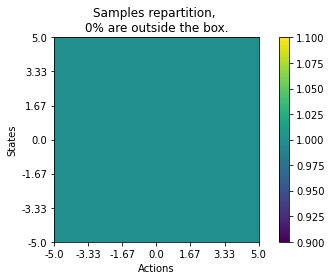

In [4]:
from pbo.sample_collection.count_samples import count_samples
from pbo.utils.state_action_mesh import StateActionMesh


samples_count, n_outside_boxes = count_samples(replay_buffer, discrete_states_boxes, discrete_actions_boxes)
samples_visu_mesh = StateActionMesh(discrete_states, discrete_actions, sleeping_time=0)

samples_visu_mesh.set_values(samples_count, zeros_to_nan=True)
samples_visu_mesh.show(
    f"Samples repartition, \n{int(100 * n_outside_boxes / n_samples)}% are outside the box."
)


## Optimal Q function

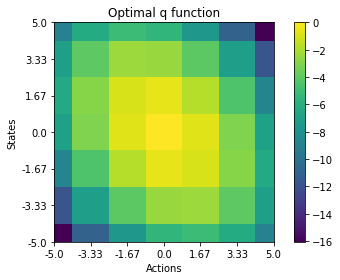

In [5]:
optimal_q = env.optimal_Q_mesh(discrete_states, discrete_actions)

q_visu_mesh = StateActionMesh(discrete_states, discrete_actions, sleeping_time)

q_visu_mesh.set_values(optimal_q)
q_visu_mesh.show("Optimal q function")

## Build q network

In [6]:
from pbo.networks.q import TheoreticalQ


q = TheoreticalQ(
    network_key=q_network_key,
    random_weights_range=None,
    random_weights_key=random_weights_key,
    action_range_on_max=action_range_on_max,
    n_actions_on_max=n_actions_on_max,
)

## Build the PBOs network and the dataloaders

In [7]:
from pbo.networks.pbo import LinearPBO, OptimalPBO, OptimalLinearPBO
from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.weights_collection.dataloader import WeightsDataLoader

replay_buffer.cast_to_jax_array()
data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)

random_weights_qs = jnp.vstack([q.random_init_weights() for _ in range(n_weights)])
data_loader_weights = WeightsDataLoader(random_weights_qs, batch_size_weights, shuffle_key)

pbo = LinearPBO(pbo_network_key, q, learning_rate, max_bellman_iterations=1)
pbo_optimal = OptimalPBO(env.A[0, 0], env.B[0, 0], env.Q[0, 0], env.R[0, 0], env.S[0, 0])
pbo_optimal_linear = OptimalLinearPBO(data_loader_weights.weights, pbo_optimal(data_loader_weights.weights))

## Train PBO on one iteration

### Define the targets of the random init weights

In [8]:
full_batch = {
    "reward": replay_buffer.rewards,
    "next_state": replay_buffer.next_states,
}
target_discrete_iterated_qs = pbo.compute_target(full_batch, data_loader_weights.weights).reshape((n_weights, n_discrete_states, n_discrete_actions))

### Training

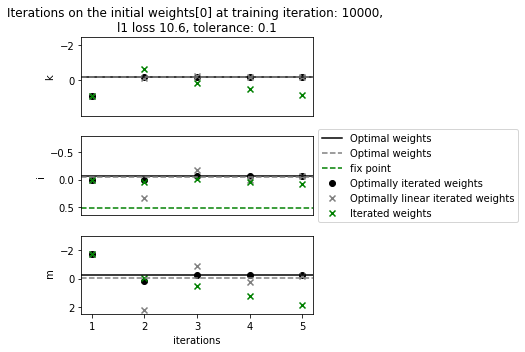

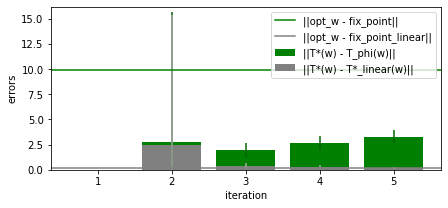

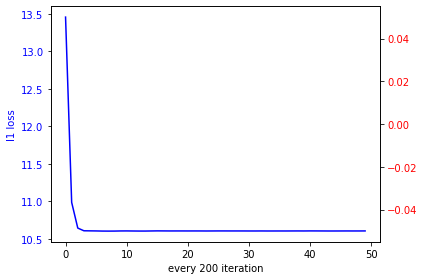

In [9]:
from pbo.utils.weights_iterator import WeightsIterator
from pbo.utils.shared_axis_plot import shared_axis_plot


# For visualization
weights_iterator = WeightsIterator(
    pbo.network.apply, pbo_optimal, pbo_optimal_linear, data_loader_weights.weights, n_iterations,
    env.A[0, 0], env.B[0, 0], env.Q[0, 0], env.R[0, 0], env.S[0, 0], env.P[0, 0], 0
)
l1_losses = []

iteration = 0
l1_loss = float("inf")

while l1_loss > tolerance and iteration < max_iterations:
    cumulative_l2_loss = 0
    
    data_loader_weights.shuffle()
    for batch_weights in data_loader_weights:
        data_loader_samples.shuffle()
        for batch_samples in data_loader_samples:
            pbo.params, pbo.optimizer_state, l2_loss = pbo.learn_on_batch(
                pbo.params, pbo.optimizer_state, batch_samples, batch_weights
            )            
            cumulative_l2_loss += l2_loss

    iteration += 1

    # Visualization
    if iteration % plot_freq == 0:
        discrete_iterated_qs = q.discretize(
            pbo.network.apply(pbo.params, data_loader_weights.weights), discrete_states, discrete_actions
        )        
        l1_loss = np.abs(target_discrete_iterated_qs - discrete_iterated_qs).mean()

        weights_iterator.iterate_on_params(pbo.params, pbo.fix_point())
        weights_iterator.show(
            f"Iterations on the initial weights[0] at training iteration: {iteration}, \nl1 loss {str(np.round(l1_loss, 2))}, tolerance: {tolerance}"
        )

        l1_losses.append(l1_loss)


shared_axis_plot(l1_losses, np.array(l1_losses) * np.nan, f"every {plot_freq} iteration", "l1 loss")